In [1]:
from model import ToyNet, UNet
import torch
import numpy as np
import logging
from sklearn import datasets

#from pytorch_lightning import LightningDataModule
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import torch.nn as nn
from torch.distributions import Normal, Categorical, MixtureSameFamily
import torch
from tmp_utils import SDEProcess, plot_trajs
import warnings
warnings.filterwarnings("ignore")
#device = 'mps'
device = 'cuda:0'
import random
from src.PCF_with_empirical_measure import PCF_with_empirical_measure

In [2]:
def init_seed(seed):
    torch.cuda.manual_seed_all(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
init_seed(1)

In [3]:
def make_s_curve_data(n_samples, noise=0.05):
    data, _ = datasets.make_s_curve(n_samples=n_samples, noise=noise)
    data = data[:, [0, 2]] /1.5
    return torch.tensor(data.astype("float32"))

def plot_traj_2d(forward_traj, backward_traj):
    steps = forward_traj.shape[2]
    vis_steps = np.linspace(0, steps-1 ,5).astype('int')
    
    for t in vis_steps:
        plt.figure(figsize=(12,3))
        plt.subplot(1, 2, 1)
        data = forward_traj[:, :, t]
        plt.scatter(data[:, 0], data[:, 1], s=5, alpha=1.0)
        #scatter_plot = plt.scatter(x_q[:, 0], x_q[:, 1], s=5, alpha=0.5, label=r'', color='red')
        plt.axis('equal')
        plt.ylabel(f't={t}')
        plt.title('Forward')
        
        plt.subplot(1, 2, 2)
        data = backward_traj[:, :, t]        
        plt.scatter(data[:, 0], data[:, 1], s=5, alpha=1.0, color='r')
        #scatter_plot = plt.scatter(x_q[:, 0], x_q[:, 1], s=5, alpha=0.5, label=r'', color='red')
        plt.axis('equal')
        plt.title('Backward')
        plt.show()

def plot_x_gen(x_real, x_gen):
    plt.figure(figsize=(12,3))
    plt.subplot(1, 2, 1)
    
    plt.scatter(x_real[:, 0], x_real[:, 1], s=5, alpha=1.0)
    #scatter_plot = plt.scatter(x_q[:, 0], x_q[:, 1], s=5, alpha=0.5, label=r'', color='red')
    plt.axis('equal')
    #plt.ylabel(f't={t}')
    plt.title('Real')
        
    plt.subplot(1, 2, 2)
    plt.scatter(x_gen[:, 0], x_gen[:, 1], s=5, alpha=1.0, color='r')
    #scatter_plot = plt.scatter(x_q[:, 0], x_q[:, 1], s=5, alpha=0.5, label=r'', color='red')
    plt.axis('equal')
    plt.title('Gen')
    plt.show()

In [4]:
data= make_s_curve_data(n_samples=128)  


In [5]:
score_net = ToyNet(data_dim=2).to(device)
total_steps = 50
num_paths = 128
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP", device=device)

In [6]:
x_data = make_s_curve_data(n_samples=num_paths)  
x_noise, traj_forward = diffusion.forward_sample(x_data)

x_gen, traj_back = diffusion.sample(torch.randn([num_paths, 2]).to(device), score_net)

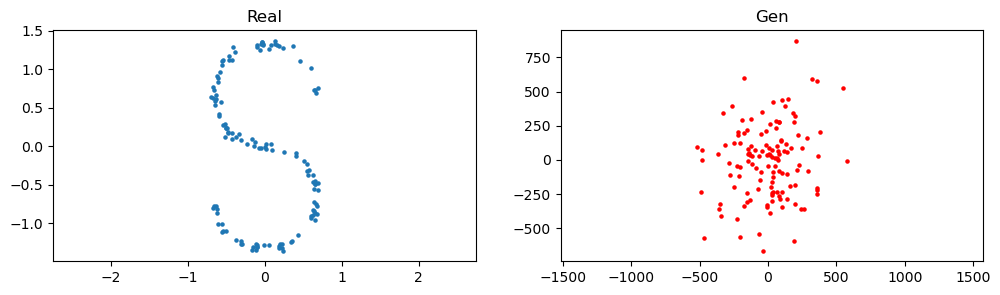

In [7]:
plot_x_gen(x_data, x_gen.cpu())

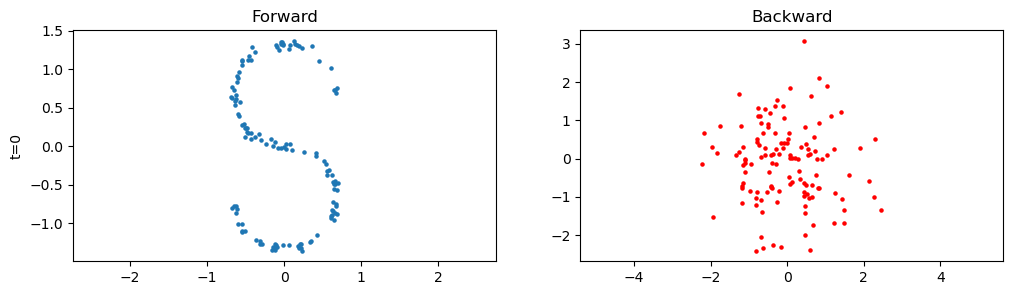

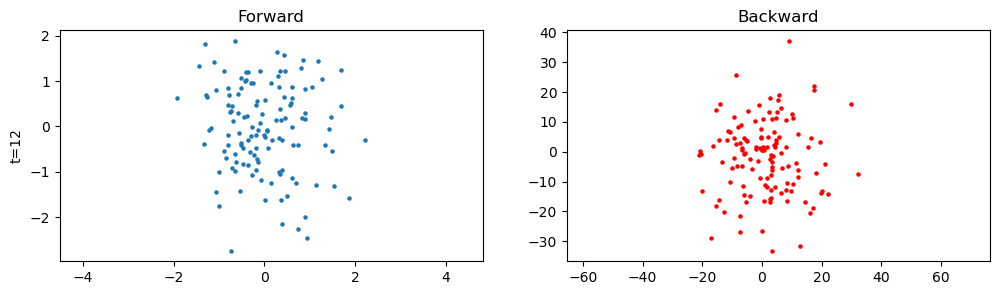

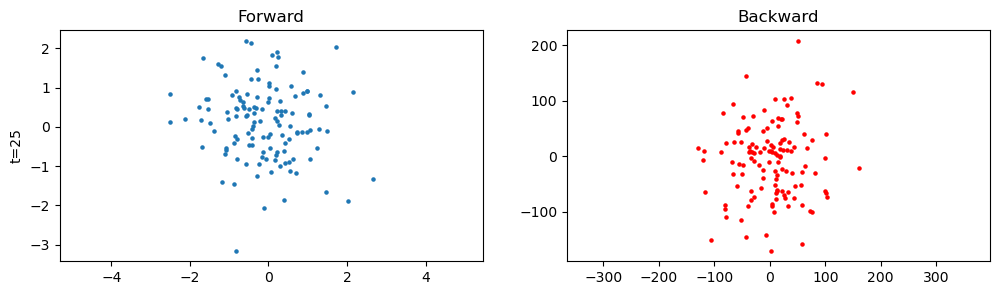

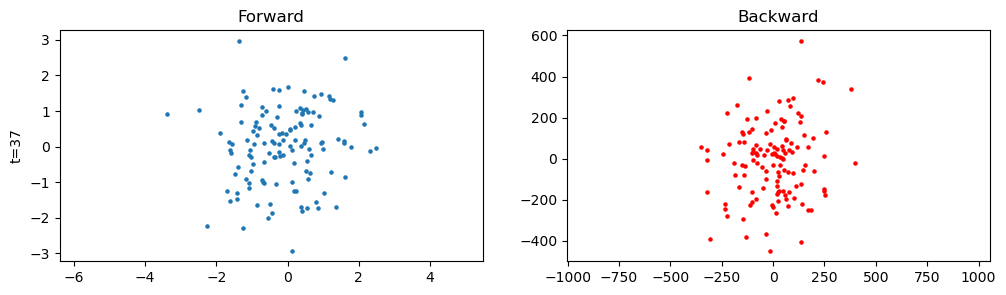

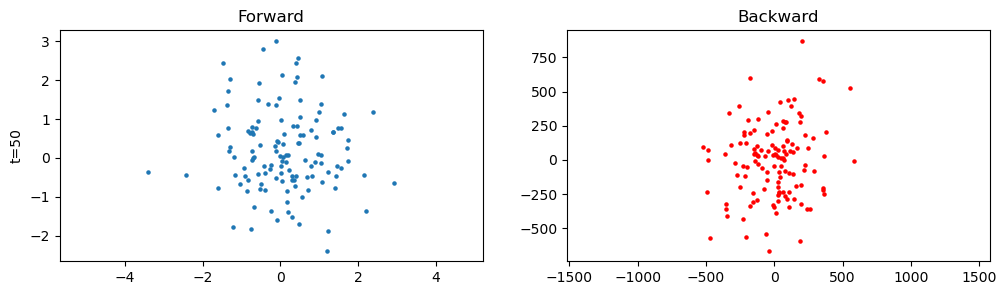

In [8]:
plot_traj_2d(traj_forward, traj_back.cpu())

In [9]:
score_net = ToyNet(data_dim=2).to(device)
total_steps = 50
num_paths = 128
diffusion = SDEProcess(discrete=False, total_steps=total_steps, sde_type="VP", device=device)

pcf = PCF_with_empirical_measure(16, 10, 2, add_time=True)
pcf = pcf.to(device)

G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-3)
D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-3)

Train the network with PCF distance and reconstrucion loss. Time dimension has been added the PCF network.

I am using min-max way to train both PCF network and score network.

Haven't test the combined loss with new backward sampling fucntion i.e. backward_sample_example that can been seen in latter block. will do later.

0 -0.9809812903404236 0.8953233957290649


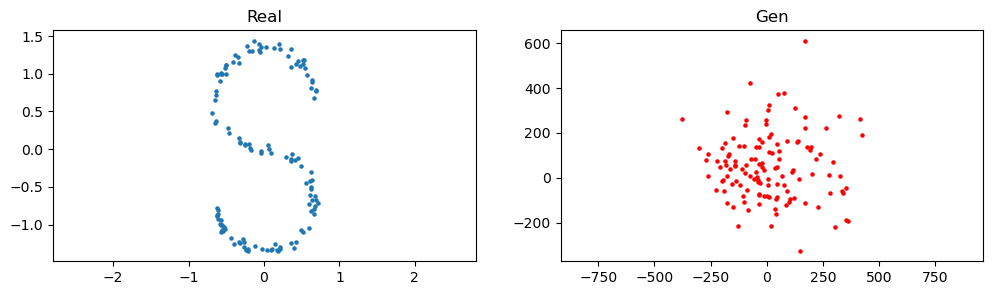

20 -1.8944191932678223 1.901107668876648
40 -1.37073814868927 1.359439730644226
60 -1.726896047592163 1.7536375522613525
80 -1.7575733661651611 1.7478713989257812
100 -1.447531819343567 1.4621950387954712


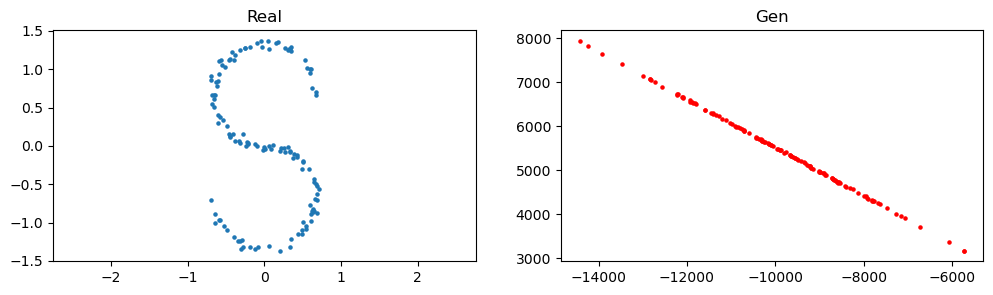

120 -1.9321818351745605 1.9462416172027588
140 -1.4495600461959839 1.4298343658447266
160 -1.5295350551605225 1.4558687210083008
180 -1.4834142923355103 1.4524953365325928
200 -1.4881274700164795 1.4767286777496338


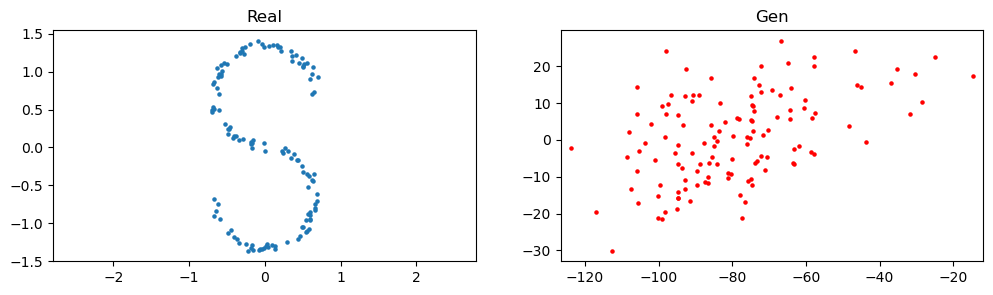

220 -1.2600840330123901 1.3737506866455078
240 -2.3445169925689697 2.3518166542053223
260 -1.7630003690719604 1.7314109802246094
280 -1.5640594959259033 1.587734341621399
300 -1.6035864353179932 1.6146599054336548


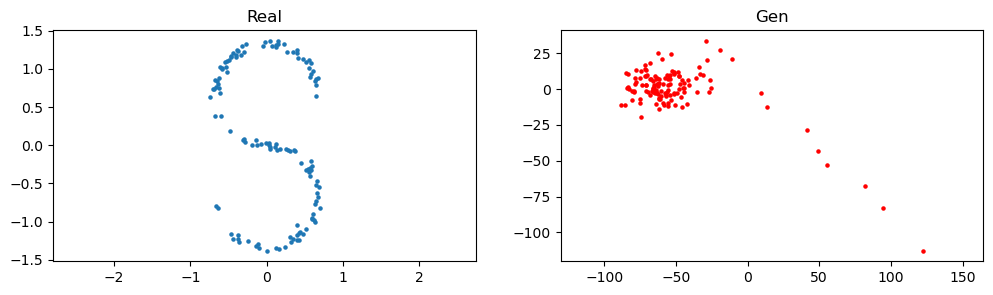

320 -2.1745147705078125 2.1647872924804688
340 -1.6091587543487549 1.5934367179870605
360 -2.305551052093506 2.30263352394104
380 -1.5071971416473389 1.5547566413879395
400 -3.071481466293335 3.069312572479248


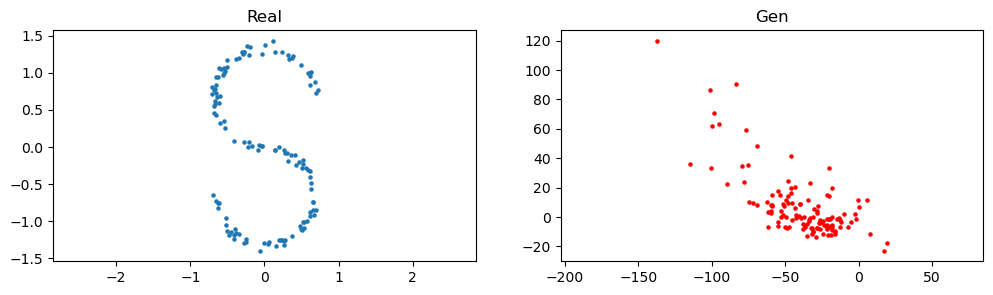

420 -2.7390568256378174 2.7005398273468018
440 -2.0746726989746094 2.1379828453063965
460 -2.8398828506469727 2.9299821853637695
480 -2.362049102783203 2.4711503982543945
500 -0.4021589756011963 0.34880530834198


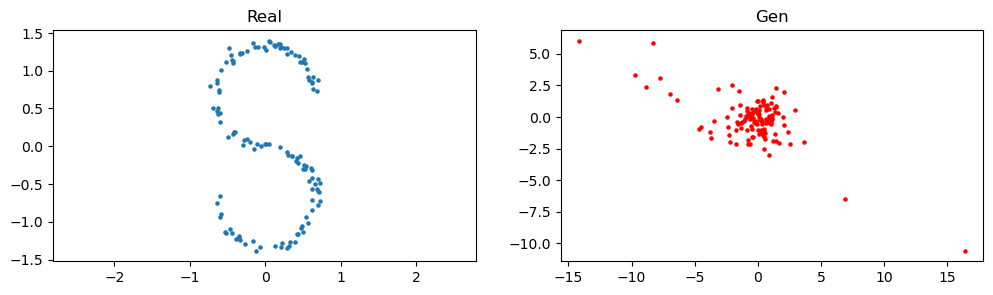

520 -0.33940815925598145 0.34930887818336487
540 -0.28110629320144653 0.3456522822380066
560 -0.33642327785491943 0.3498726487159729
580 -0.34606993198394775 0.29730910062789917
600 -0.4702532887458801 0.3965233564376831


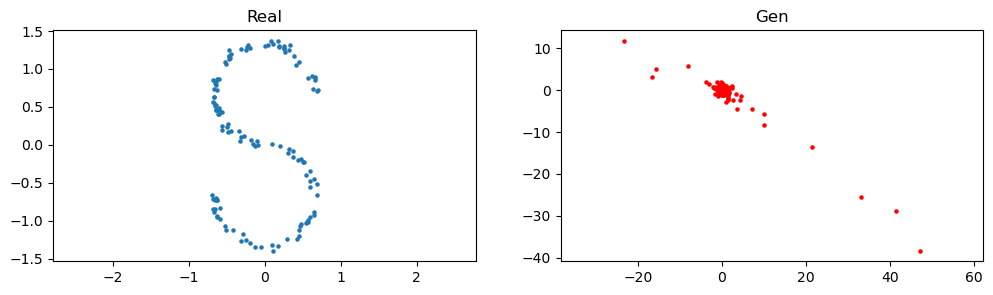

620 -0.229521244764328 0.2383265197277069
640 -0.5075573921203613 0.586550772190094
660 -0.8182660937309265 0.7093445658683777
680 -0.2658079266548157 0.3463214933872223
700 -0.8332446813583374 0.6982704401016235


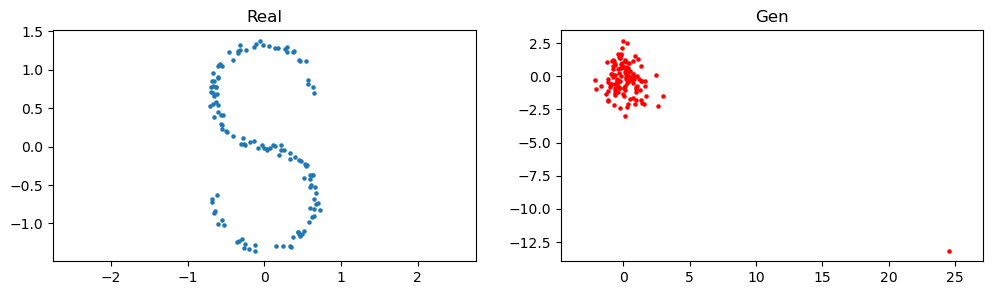

720 -0.3430331349372864 0.37896427512168884
740 -0.2744504511356354 0.2449105679988861
760 -0.2933494746685028 0.30221307277679443
780 -0.23775030672550201 0.3536924421787262
800 -0.37212732434272766 0.27424395084381104


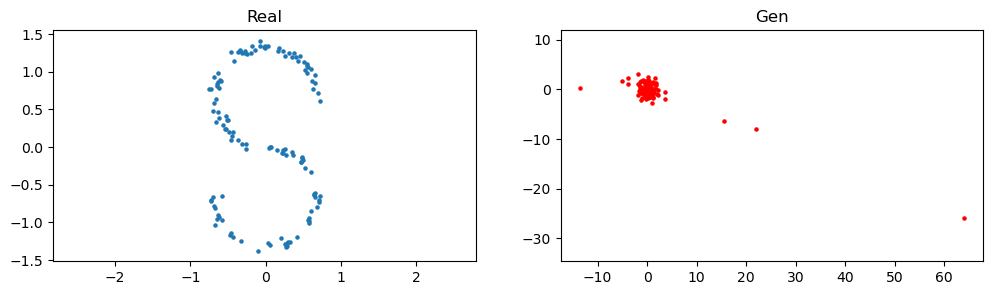

820 -0.31320756673812866 0.3133530616760254
840 -0.37265682220458984 0.33057355880737305
860 -0.40231114625930786 0.33838051557540894
880 -0.3381694555282593 0.2919110655784607
900 -0.2616180181503296 0.3682893216609955


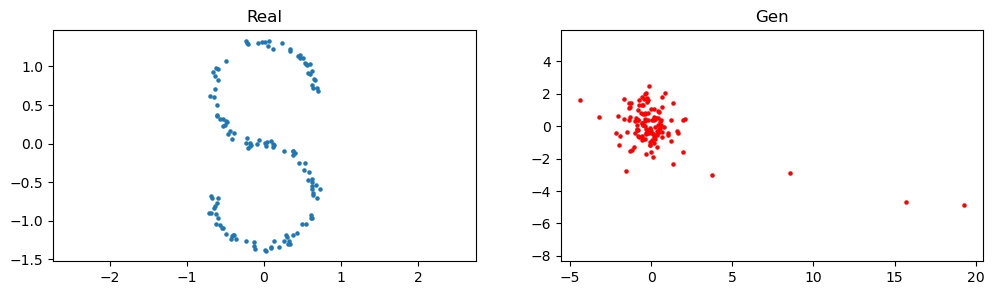

920 -0.2945626974105835 0.2717410624027252
940 -0.2858531177043915 0.3191382884979248
960 -0.2549680471420288 0.329018235206604
980 -0.4523223340511322 0.3201582431793213
1000 -0.2943747639656067 0.32192525267601013


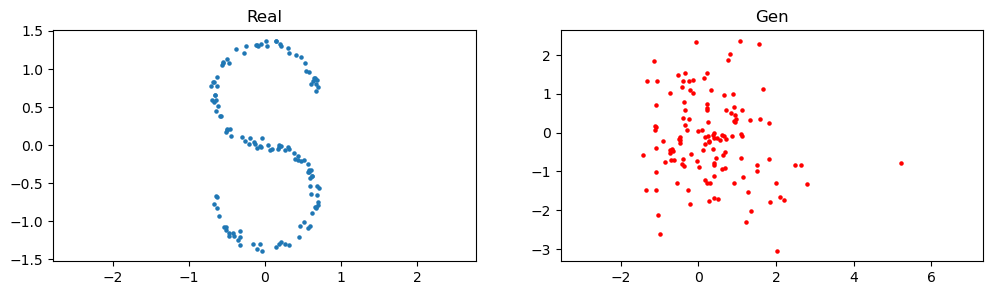

1020 -0.3418668210506439 0.26008692383766174
1040 -0.31521153450012207 0.32173100113868713
1060 -0.26924389600753784 0.3829957842826843
1080 -0.2837086617946625 0.33093249797821045
1100 -0.21096253395080566 0.33225902915000916


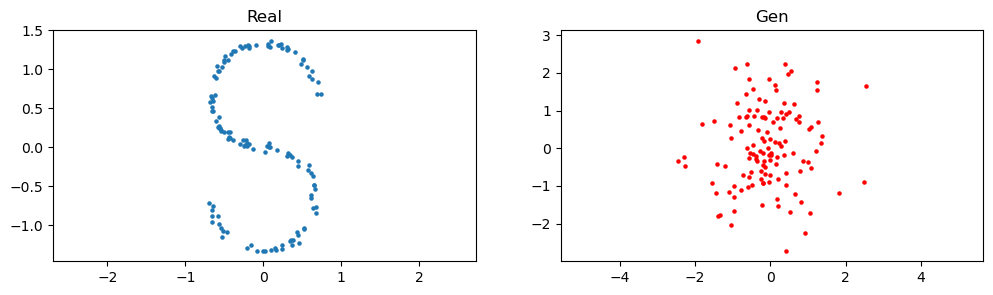

1120 -0.3985968828201294 0.2647196650505066
1140 -0.37666529417037964 0.2927160859107971
1160 -0.3574512302875519 0.39748287200927734
1180 -0.33421432971954346 0.3804492950439453
1200 -0.3645477890968323 0.3707047700881958


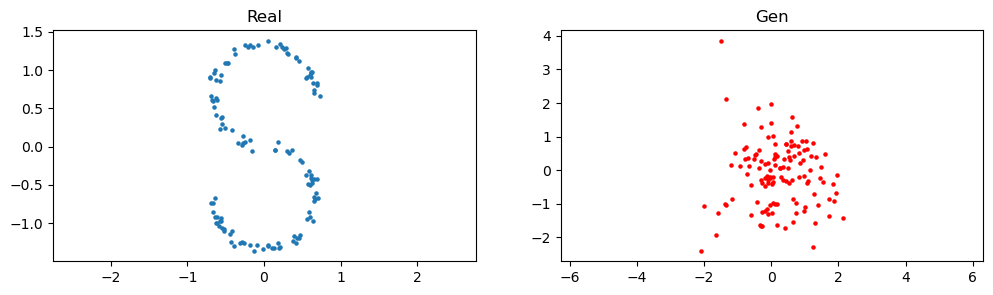

1220 -0.3584974408149719 0.2607562243938446
1240 -0.9824302792549133 0.8302899599075317
1260 -0.2664879560470581 0.283840149641037
1280 -0.6075345873832703 0.7724269032478333
1300 -0.2524033188819885 0.28661057353019714


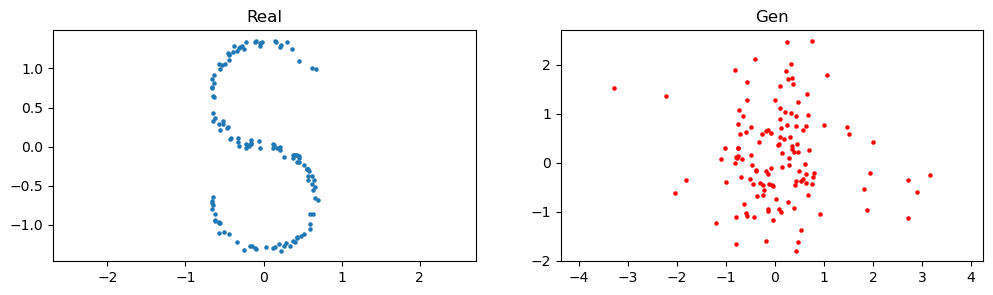

1320 -0.4477548599243164 0.4283753037452698
1340 -0.2270527333021164 0.35281121730804443
1360 -0.30963847041130066 0.34601953625679016
1380 -0.3060859739780426 0.3462643623352051
1400 -0.26851657032966614 0.24981124699115753


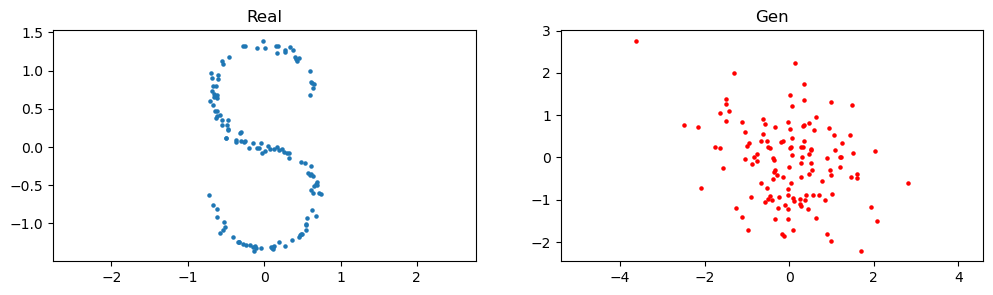

1420 -0.3217806816101074 0.3200805187225342
1440 -0.38096484541893005 0.27516183257102966
1460 -0.28687721490859985 0.2261703610420227
1480 -0.35335612297058105 0.4186963140964508
1500 -0.3284010887145996 0.26515811681747437


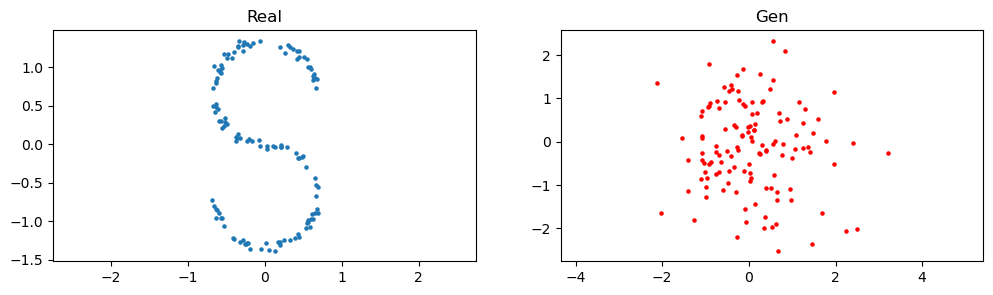

1520 -0.33784812688827515 0.27631300687789917
1540 -0.22075730562210083 0.34403693675994873
1560 -0.29489845037460327 0.2764580249786377
1580 -0.21407729387283325 0.23290477693080902
1600 -0.2634490132331848 0.3223865032196045


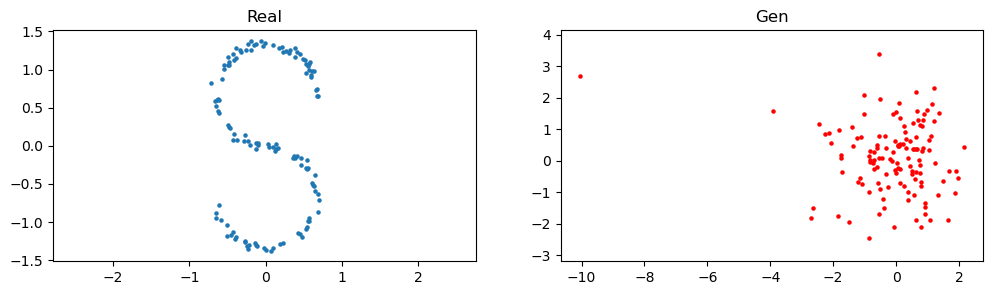

1620 -0.476154088973999 0.5832337141036987
1640 -0.3069617748260498 0.259215384721756
1660 -0.28602302074432373 0.266964316368103
1680 -0.2845984399318695 0.39901721477508545
1700 -0.3274322748184204 0.3600486218929291


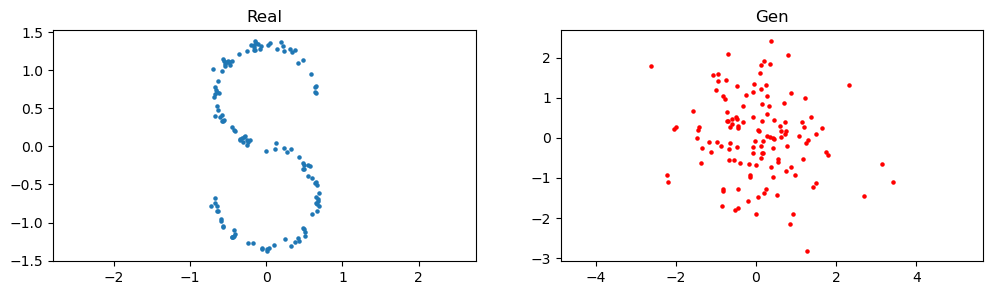

1720 -0.2679809331893921 0.2620626389980316
1740 -0.4909515380859375 0.4131554663181305
1760 -1.1026430130004883 0.7428579926490784
1780 -0.3771706819534302 0.35488221049308777
1800 -0.34323549270629883 0.30239272117614746


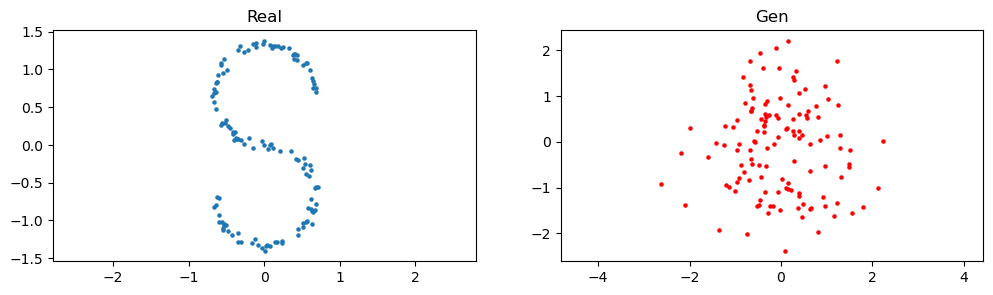

1820 -0.31795424222946167 0.24852244555950165
1840 -0.3070261776447296 0.26687490940093994
1860 -0.3194684386253357 0.2930527329444885
1880 -0.2879998981952667 0.3008683919906616
1900 -0.26094189286231995 0.24907918274402618


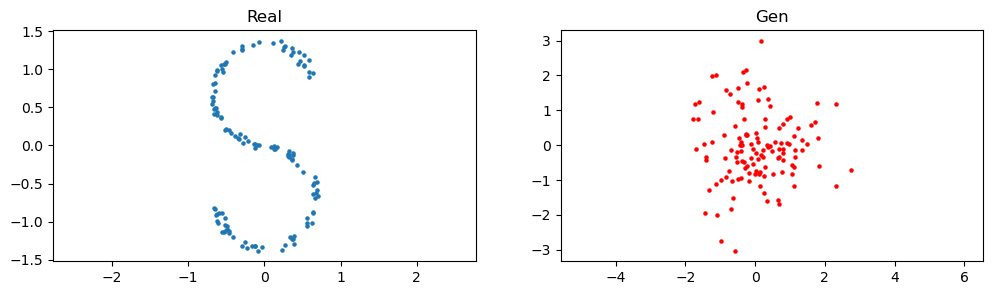

1920 -0.28304240107536316 0.22107256948947906
1940 -0.2709721028804779 0.3578779697418213
1960 -0.32795077562332153 0.29083481431007385
1980 -0.41468706727027893 0.3912808895111084
2000 -0.2258390635251999 0.23394055664539337


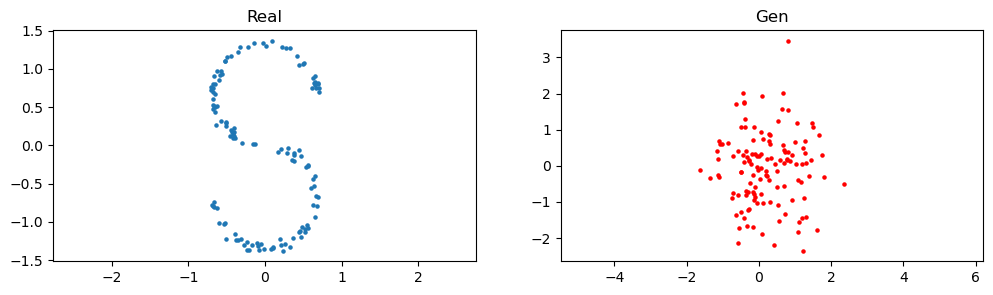

2020 -0.30408865213394165 0.2391991913318634
2040 -0.3727109432220459 0.417729914188385
2060 -0.23504120111465454 0.2298058718442917
2080 -0.31052663922309875 0.2675110399723053
2100 -0.3147069811820984 0.3335636258125305


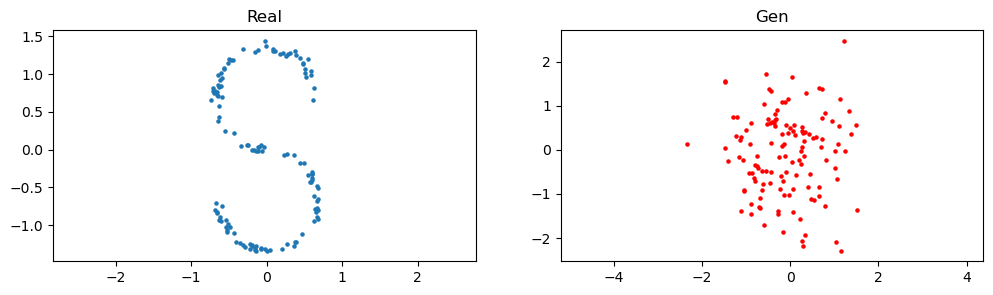

2120 -0.4275973439216614 0.3828648626804352
2140 -0.6750088334083557 0.6472231149673462
2160 -0.23791800439357758 0.28739649057388306
2180 -0.38791394233703613 0.281582772731781
2200 -0.4058293104171753 0.4422212839126587


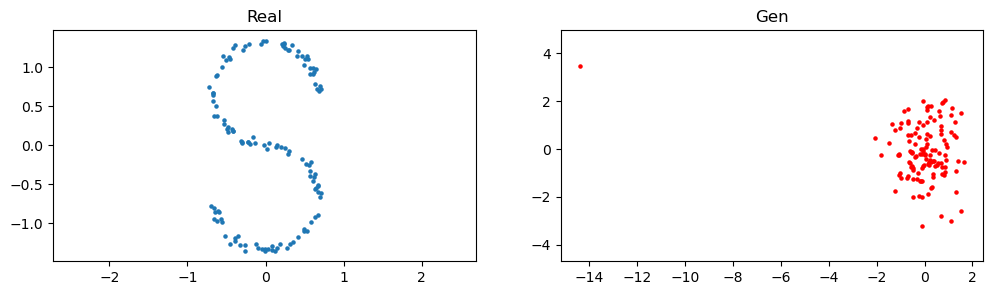

2220 -0.2912101745605469 0.244666188955307
2240 -0.2583267390727997 0.2888374924659729
2260 -0.3156397342681885 0.28439825773239136
2280 -0.28134775161743164 0.27635103464126587
2300 -0.46387243270874023 0.3912208676338196


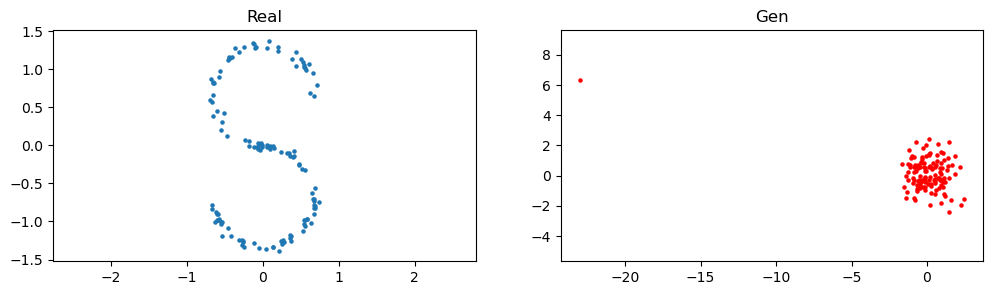

2320 -0.3206825256347656 0.33078083395957947
2340 -0.29696786403656006 0.2601613402366638
2360 -0.37828803062438965 0.39345917105674744
2380 -0.280256450176239 0.36525601148605347
2400 -0.2936862111091614 0.3038921356201172


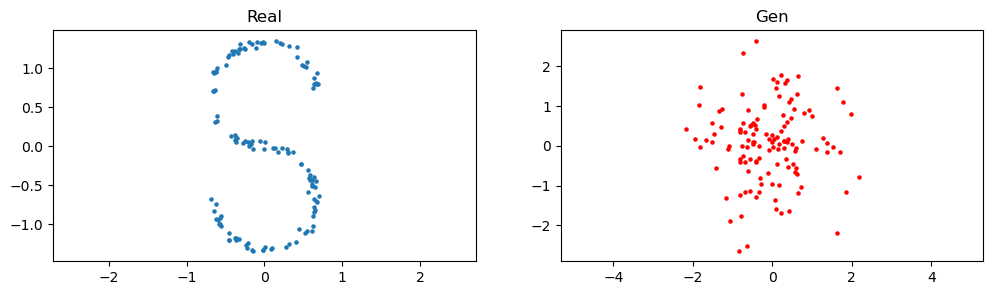

2420 -0.3485606014728546 0.2881361246109009
2440 -0.2389468252658844 0.3043753504753113
2460 -0.3344593942165375 0.33547794818878174
2480 -0.3551676273345947 0.3077937364578247
2500 -0.49708396196365356 0.4370577335357666


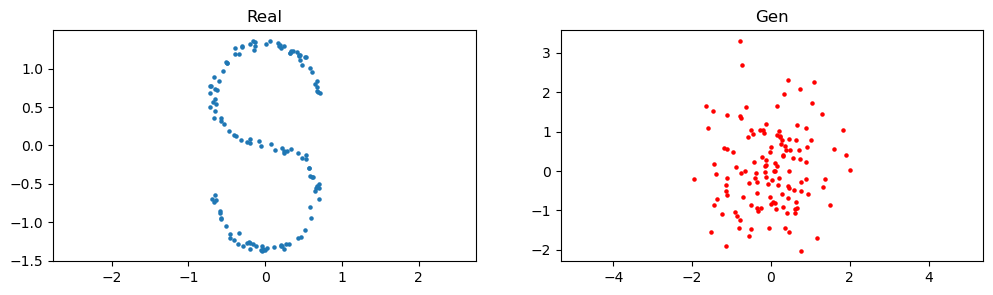

2520 -0.28597569465637207 0.33989447355270386
2540 -0.3581671714782715 0.30846571922302246
2560 -0.2642683982849121 0.30334872007369995
2580 -0.3166377544403076 0.3369007706642151
2600 -0.27109044790267944 0.21277570724487305


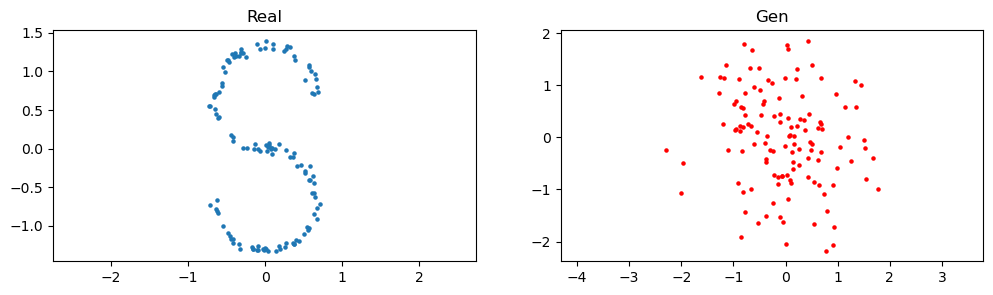

2620 -0.23251838982105255 0.3322535753250122
2640 -0.2854650616645813 0.35750994086265564
2660 -0.4401947855949402 0.4486481547355652
2680 -1.1637041568756104 0.8991638422012329
2700 -0.6299704313278198 0.592525064945221


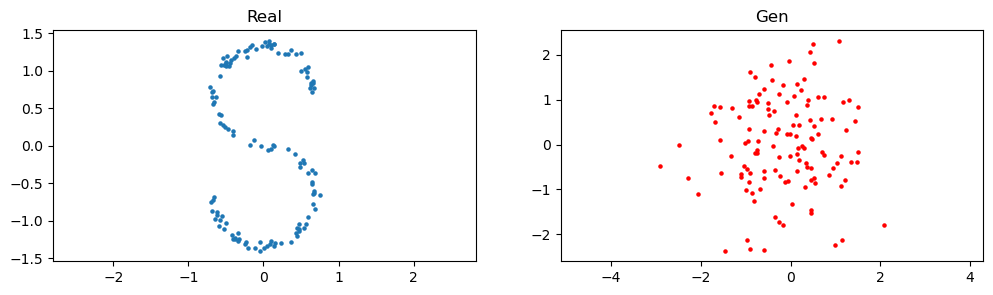

2720 -0.26202309131622314 0.24123258888721466
2740 -0.2881366014480591 0.3479018211364746
2760 -0.23895984888076782 0.28772151470184326
2780 -0.29939547181129456 0.270931214094162
2800 -0.604246199131012 0.6184672117233276


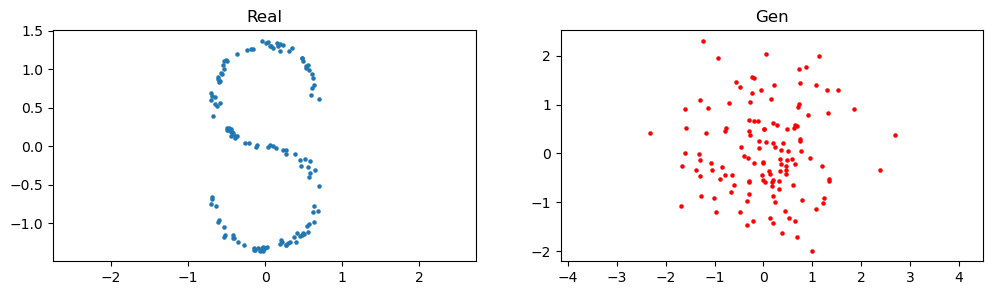

2820 -0.2905970811843872 0.2862144708633423
2840 -0.318858802318573 0.32644137740135193
2860 -0.3109385371208191 0.3380303978919983
2880 -0.362991601228714 0.37134164571762085
2900 -0.2764005959033966 0.2726125717163086


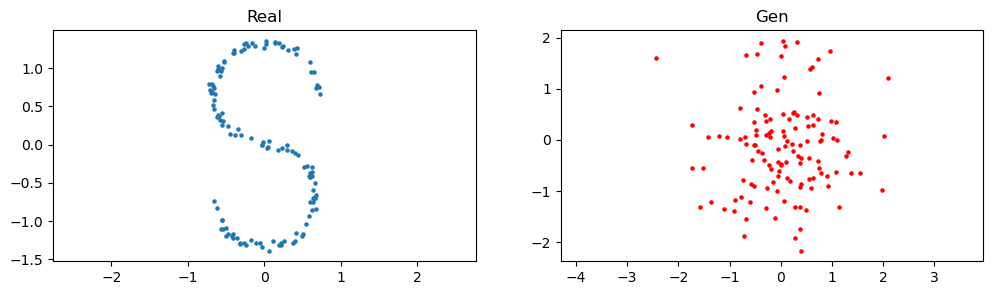

2920 -0.2897407114505768 0.32328879833221436
2940 -0.2488992065191269 0.3005822002887726
2960 -0.19814307987689972 0.18315507471561432
2980 -0.28031688928604126 0.2423717975616455
3000 -0.29163163900375366 0.2608183026313782


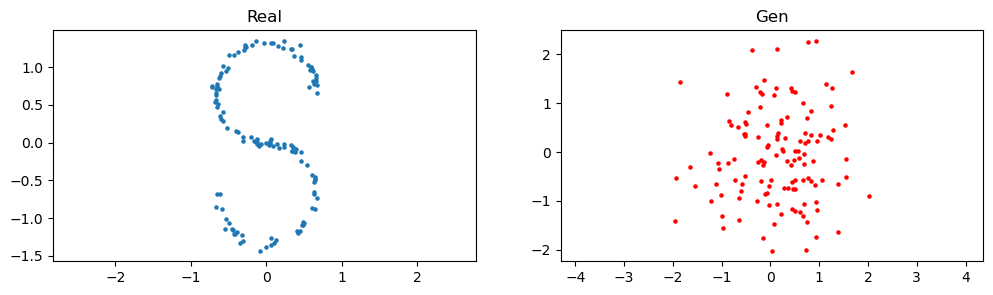

3020 -0.3080136775970459 0.2815178334712982
3040 -0.27409714460372925 0.480186402797699
3060 -0.7132079005241394 0.9135656356811523
3080 -0.35440534353256226 0.30956581234931946
3100 -0.33743277192115784 0.3362634778022766


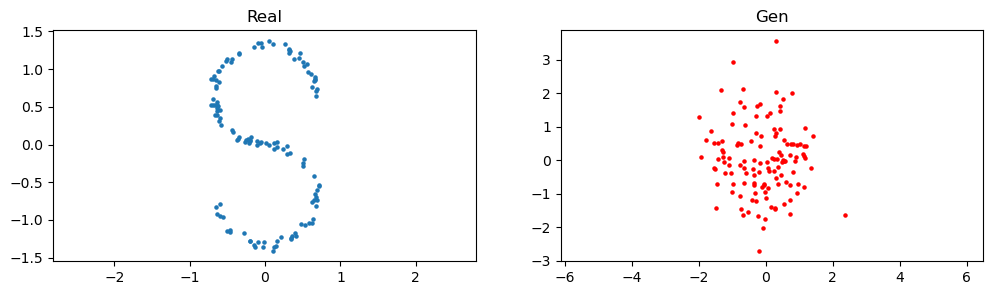

3120 -0.20085351169109344 0.40489497780799866
3140 -0.7445551753044128 1.0854572057724
3160 -0.31196606159210205 0.32808631658554077
3180 -0.4107617139816284 0.19329041242599487
3200 -0.26937440037727356 0.22657376527786255


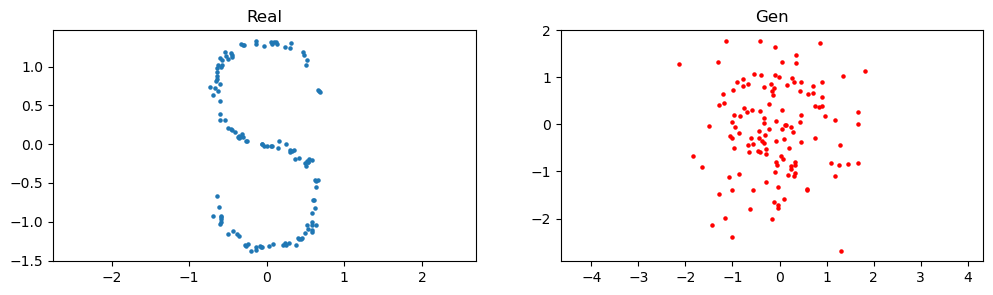

3220 -0.31219199299812317 0.2545101046562195
3240 -0.2210790067911148 0.3749082088470459
3260 -0.25628283619880676 0.24146977066993713
3280 -0.24744845926761627 0.2575501799583435
3300 -0.45539939403533936 0.4302283823490143


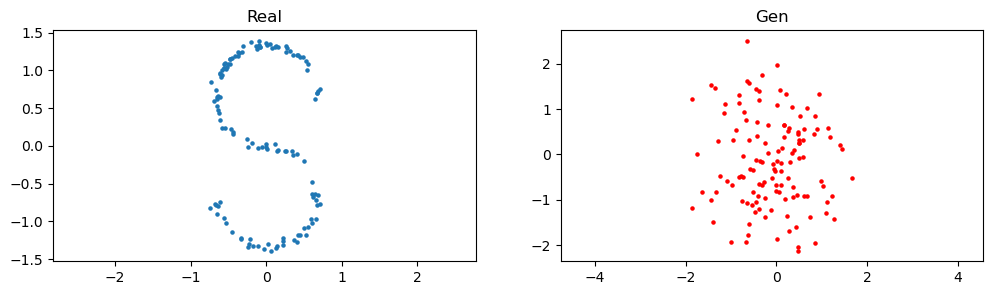

3320 -0.4669848680496216 0.37247195839881897
3340 -0.30462121963500977 0.3139491677284241
3360 -0.2646399736404419 0.2923294007778168
3380 -0.25193583965301514 0.2744879424571991
3400 -0.28199952840805054 0.31429168581962585


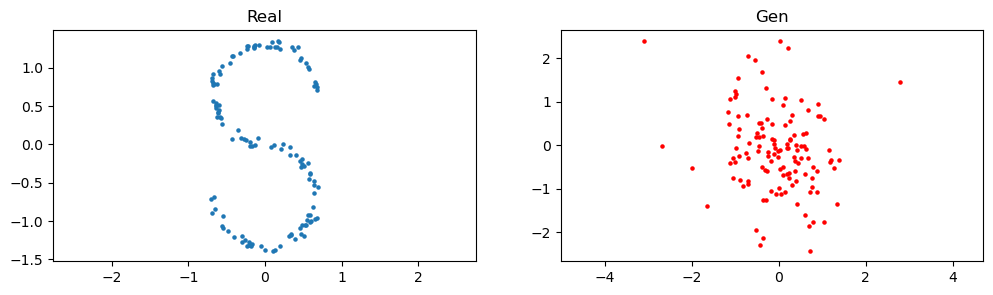

3420 -0.33189499378204346 0.3951839506626129
3440 -0.2819746732711792 0.3156660497188568
3460 -0.3629528880119324 0.2523747682571411
3480 -0.34866687655448914 0.20281502604484558
3500 -0.21955528855323792 0.22454020380973816


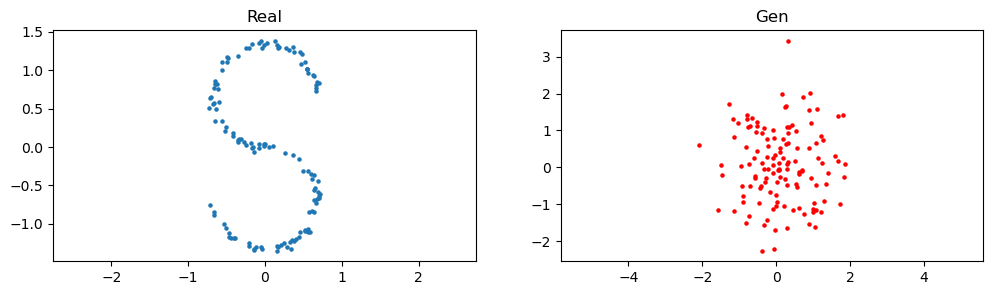

3520 -0.3943699598312378 0.3777218759059906
3540 -0.7598430514335632 0.5736838579177856
3560 -0.26655107736587524 0.2699908912181854
3580 -0.34732571244239807 0.264640748500824
3600 -0.3007891774177551 0.2552781105041504


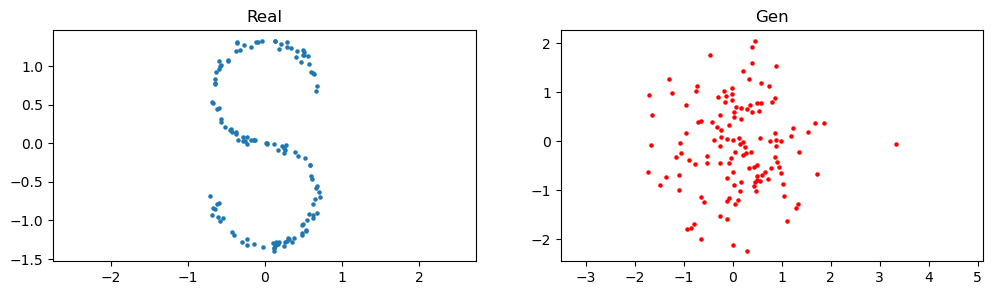

3620 -0.3550506830215454 0.31122368574142456
3640 -0.2402001917362213 0.31074467301368713
3660 -0.32920652627944946 0.35520607233047485
3680 -0.25883081555366516 0.21873106062412262
3700 -0.5485349893569946 0.44591090083122253


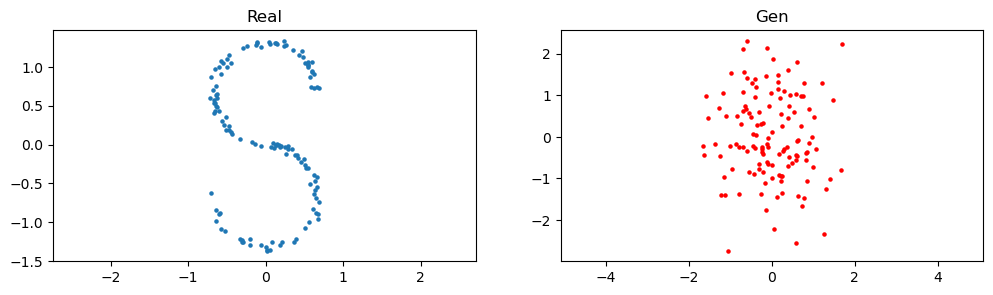

3720 -0.22901242971420288 0.29715943336486816
3740 -0.34670647978782654 0.3091876208782196
3760 -0.3132340908050537 0.31762924790382385
3780 -0.35779082775115967 0.35657864809036255
3800 -0.3657516837120056 0.3522739112377167


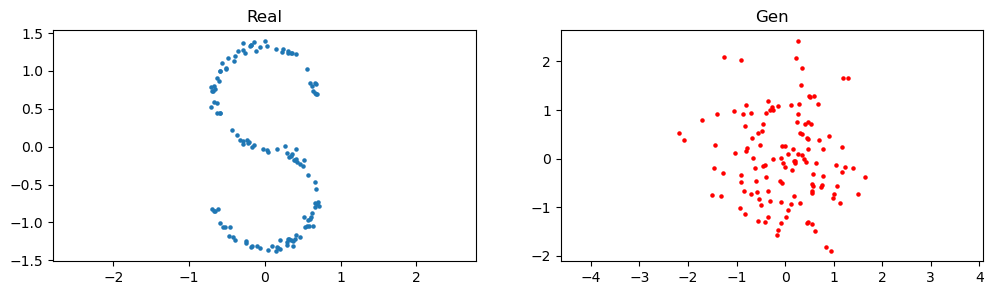

3820 -0.325188010931015 0.26934680342674255
3840 -0.2293960005044937 0.32002198696136475
3860 -0.38863876461982727 0.2581537365913391
3880 -0.1997423768043518 0.3214176893234253
3900 -0.27612945437431335 0.3697199821472168


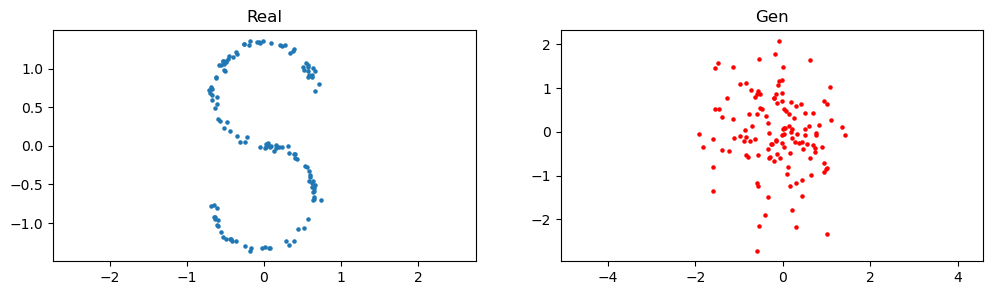

3920 -0.2689918279647827 0.22438788414001465
3940 -0.2936052083969116 0.3611944317817688
3960 -0.39405572414398193 0.278001606464386
3980 -0.2725488543510437 0.2915981709957123
4000 -0.26202595233917236 0.32493147253990173


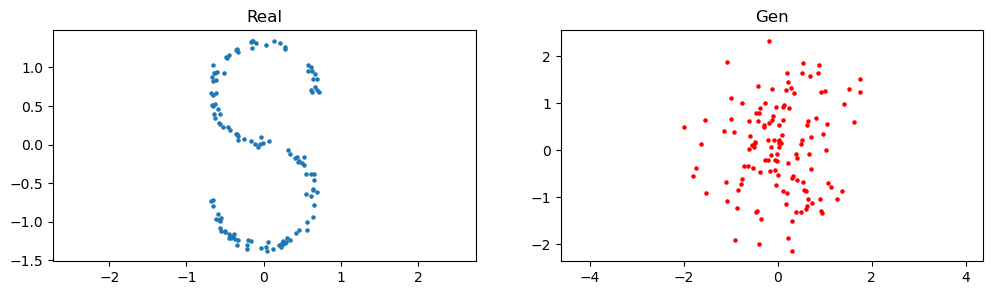

4020 -0.3787381649017334 0.27527233958244324
4040 -0.42604196071624756 0.3732452988624573
4060 -0.30425000190734863 0.31236591935157776
4080 -0.6672408580780029 0.3366372883319855
4100 -0.24471986293792725 0.2908972203731537


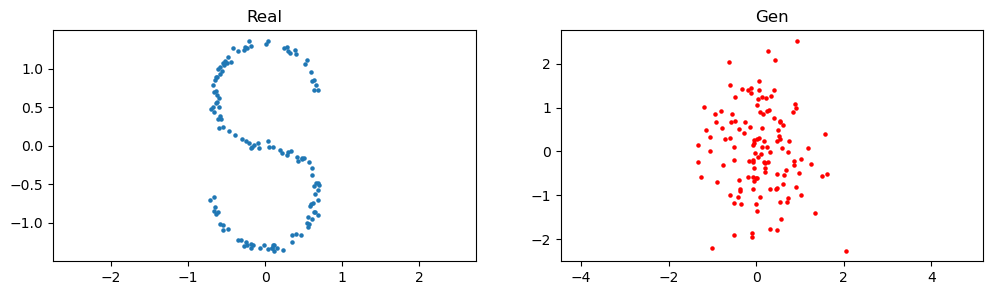

4120 -0.3318719267845154 0.3787102699279785
4140 -0.4077453017234802 0.31493812799453735
4160 -0.24739012122154236 0.36713045835494995
4180 -0.3641173839569092 0.3026525378227234
4200 -0.3338204026222229 0.29467034339904785


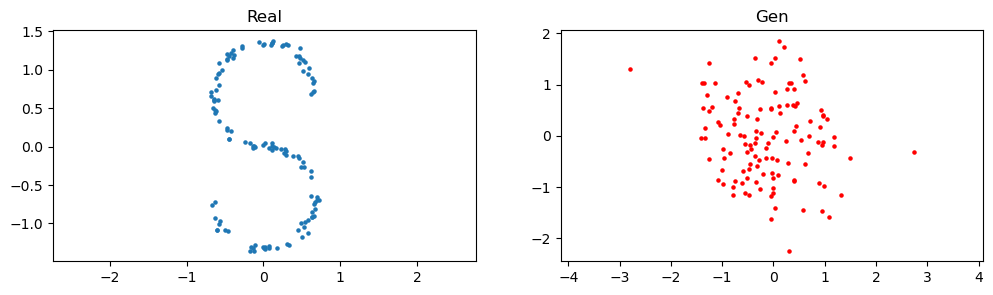

4220 -0.27105000615119934 0.3009997010231018
4240 -0.2899843454360962 0.246462881565094
4260 -0.41173434257507324 0.32370540499687195
4280 -0.31469231843948364 0.2896299958229065
4300 -0.2845097780227661 0.34132224321365356


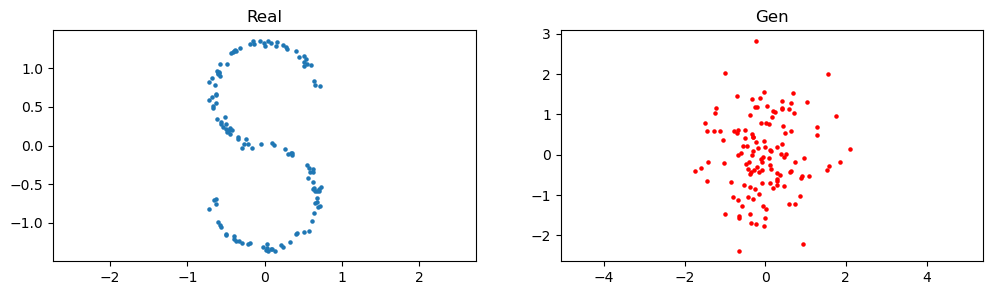

4320 -0.2578888535499573 0.3138188421726227
4340 -0.28820908069610596 0.36520230770111084
4360 -0.23472173511981964 0.2969864010810852
4380 -0.3188731074333191 0.2968030571937561
4400 -0.2595369815826416 0.44930964708328247


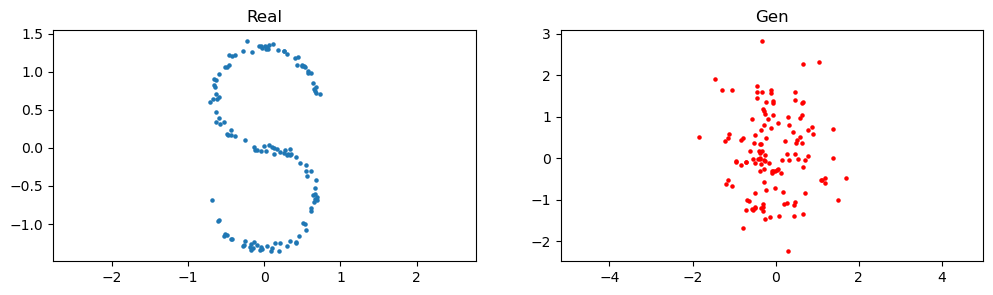

4420 -0.3249221444129944 0.3737803101539612
4440 -0.267564058303833 0.2870985269546509
4460 -0.2688246965408325 0.34866634011268616
4480 -0.2991696000099182 0.3111690282821655
4500 -0.3837297856807709 0.4801846742630005


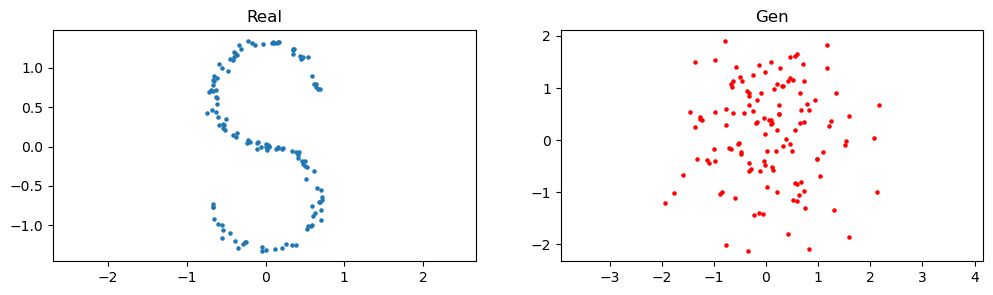

4520 -0.2641155421733856 0.2701754570007324
4540 -0.3379589319229126 0.37091293931007385
4560 -0.37569868564605713 0.3243386447429657
4580 -0.2788821756839752 0.33992457389831543
4600 -0.3357826769351959 0.3096733093261719


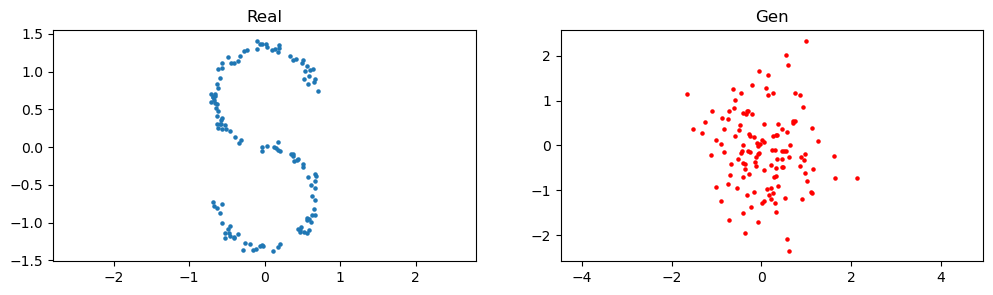

4620 -0.2888684570789337 0.32010313868522644
4640 -0.30439460277557373 0.315035879611969
4660 -0.2520838975906372 0.30434954166412354
4680 -0.3066037893295288 0.3456246852874756
4700 -0.2330421507358551 0.27466481924057007


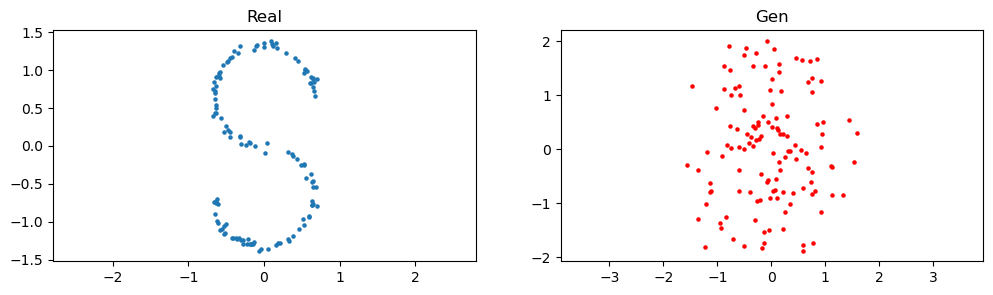

4720 -0.3723629117012024 0.3432321846485138
4740 -0.34705573320388794 0.28918129205703735
4760 -0.24272531270980835 0.23235663771629333
4780 -0.2623139023780823 0.4126107394695282
4800 -0.38427239656448364 0.42242980003356934


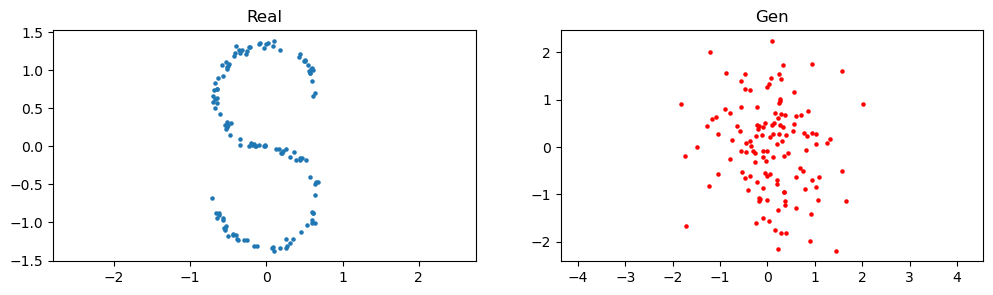

4820 -0.2434018850326538 0.2784339189529419
4840 -0.29141098260879517 0.28989705443382263
4860 -0.2796971797943115 0.34971150755882263
4880 -0.2817543148994446 0.251785546541214
4900 -0.32081496715545654 0.3198840320110321


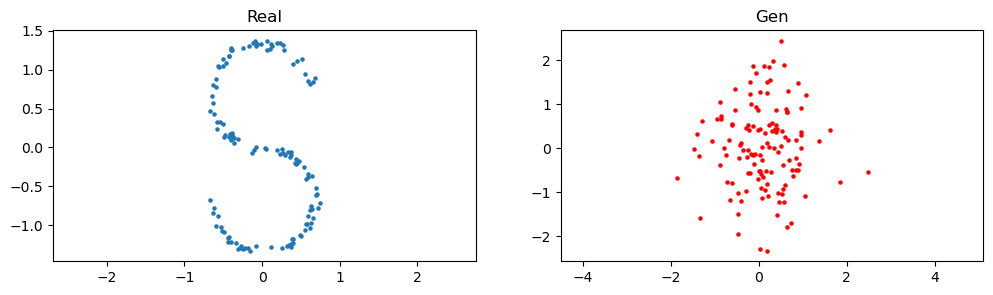

4920 -0.33560219407081604 0.3531208634376526
4940 -0.2592455744743347 0.3167768120765686
4960 -0.2883237600326538 0.3630092740058899
4980 -0.361190527677536 0.24399861693382263
5000 -0.26517170667648315 0.327045738697052


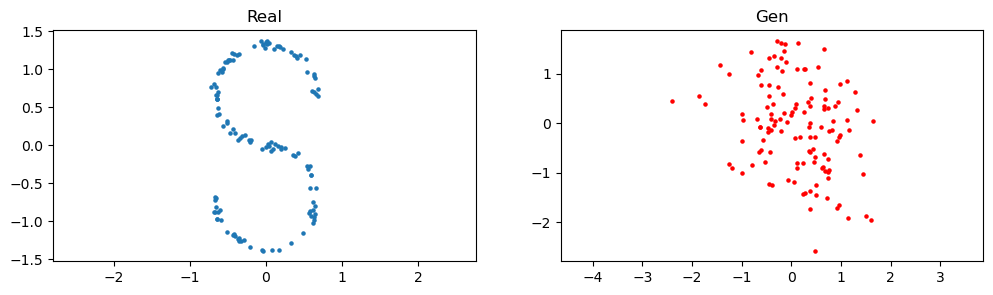

In [10]:
# RNN structure
num_epochs = 5001
for i in range(num_epochs):
    if 500 <i <=800:
        G_opt = torch.optim.Adam(score_net.parameters(), lr=1e-4)
        D_opt = torch.optim.Adam(pcf.parameters(), lr=1e-4)
    elif i>800:
        G_opt = torch.optim.Adam(score_net.parameters(), lr=5e-5)
        D_opt = torch.optim.Adam(pcf.parameters(), lr=5e-5)

    # Train the discriminator
    # Sample the forward trajs
    x_data = make_s_curve_data(n_samples=num_paths)  
    x_noise, traj_forward = diffusion.forward_sample(x_data)
    traj_forward = traj_forward.to(device)
    #traj_forward_flip = torch.fliplr(traj_forward)
    traj_forward_flip = torch.flip(traj_forward, dims=[2])

    length = 5
    t = np.random.randint(0, traj_forward.shape[2]-length+1)
    #t=0
    #length = total_steps + 1
    x_t = traj_forward[:, :, t]
    traj_forward_sub = traj_forward_flip[:, :, t:t+length]
    # train the PCF network as a discriminator. We want PCF has a great ablitily to distinguish the real data and the generated data.
    # So we train the PCF to maxmise the distance between the real data and the generated data.
    #with torch.no_grad():
        # Sample the backward trajs
    z = torch.randn([num_paths, 2]).to(device)
    x_gen, traj_back = diffusion.sample(z, score_net)

    traj_back_sub = traj_back[:, :, t:t+length]
    #traj_forward_flip_trim = traj_forward_flip[:, t:t+length]
        #traj_forward_flip_cat = torch.cat((traj_forward_flip_trim.view([-1, length, 1]),traj_forward_flip_trim.view([-1, length, 1])),0)
    #print(traj_back_sub.shape, traj_forward_sub.shape)
    pcf.train()
    D_loss = -pcf.distance_measure(traj_forward_sub.permute(0, 2, 1), traj_back_sub.permute(0, 2, 1), Lambda=1.0)

    D_opt.zero_grad()
    D_loss.backward()
    D_opt.step()



    # train the score network to minmise the distance between the real data and the generated data
    # Sample the backward trajs
    z = torch.randn([num_paths, 2]).to(device)
    x_gen, traj_back = diffusion.backward_sample(z, score_net)
    #traj_forward_flip_trim = traj_forward_flip[:, t:t+length]
    traj_back_sub = traj_back[:, :, t:t+length]
    pcf.eval()

    #G_loss =  pcf.distance_measure(traj_forward_flip_cat, traj_back.view([-1, total_steps+1, 1]), Lambda=1.0) + \
        #0.5*torch.mean(((traj_forward - traj_back_flip1)**2).reshape(traj_forward.shape[0], -1), dim=(0,1))
    G_loss = (pcf.distance_measure(traj_forward_sub.permute(0, 2, 1), traj_back_sub.permute(0, 2, 1), Lambda=1.0))
    G_opt.zero_grad()
    G_loss.backward()
    G_opt.step()
    if i % 20 == 0:

        print(i, D_loss.item() , G_loss.item())
    if i % 100 == 0:
        #with torch.no_grad():
        plot_x_gen(x_data, x_gen.detach().cpu())